### **Neural Machine Translation Using a Custom-Implemented Transformer Model**

This project implements an encoder–decoder Transformer model (Vaswani et al.) from scratch for German-to-English machine translation using the Multi30k dataset, which contains approximately 30,000 English–German sentence pairs.

The model architecture includes custom implementations of key Transformer components, including scaled dot-product attention, multi-head attention, positional encoding, and position-wise feedforward layers.

In [ ]:
pip install -U torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


**Spacy** is an open-source natural language processing (NLP) library written in Python. It is designed to be fast, efficient, and easy to use for various NLP tasks such as tokenization, part-of-speech tagging, named entity recognition, dependency parsing, and more.    
I used below commands to download the German and English language models for the spaCy library, respectively.   
`de_core_news_sm` model includes pre-trained word vectors and tokenization rules for the German language.     
`en_core_web_sm` model also includes pre-trained word vectors and tokenization rules, but for the English language.

In [ ]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Importing Libraries:**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import numpy as np
import pandas as pd
import spacy
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# Set the seed for reproducibility
SEED = 1234

# Set the random seed for Python's random module
random.seed(SEED)
# Set the random seed for numpy
np.random.seed(SEED)
# Set the random seed for PyTorch on CPU
torch.manual_seed(SEED)
# Set the random seed for PyTorch on GPU (if available)
torch.cuda.manual_seed(SEED)
# Set the deterministic mode for PyTorch's cuDNN backend for GPU
torch.backends.cudnn.deterministic = True

In [ ]:
# training data
train_en=open('/content/train.en',encoding='utf-8').read().split('\n')
train_de=open('/content/train.de',encoding='utf-8').read().split('\n')
# test data
test_en=open('/content/test.en',encoding='utf-8').read().split('\n')
test_de=open('/content/test.de',encoding='utf-8').read().split('\n')
# validation data
val_en=open('/content/val.en',encoding='utf-8').read().split('\n')
val_de=open('/content/val.de',encoding='utf-8').read().split('\n')

In [ ]:
# Load the German language model
spacy_de = spacy.load('de_core_news_sm')

# Load the English language model
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
# Setting the PyTorch device to CUDA (GPU) if available, otherwise CPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Preparing Data for the encode and decoder:**   
  1. store data in dataframe with two coulmns. First col for source language and second col for target language.

  2. save dataframes in .csv files

  3. pass address of train,validation,test .csv files as input to torchtext.data.TabularDataset which will output train_data,validation_data,test_data

  4. Now index all tokens in german and english using SRC.build_vocab and TRG.build_vocab respectively where SRC and TRG are field class instances

  5. Creating Batches using BucketIterator.

After performing all above steps we will get train_iterator, valid_iterator, test_iterator with specified batch_size.

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
#defining instance of field class which will perform preprocessing of data. NOTE: Always consider SRC as langauge that is to be translated and TRG as lang to which translation is aimed at.

# Define a Field object for the source language (German)
SRC=Field(tokenize=tokenize_de,
          init_token='',
          eos_token='',
          lower=True,                   #Whether to lowercase the text in field.
          batch_first=True)             #since model expects - tensors with batch_dimension first
                                        #The model expects data to be fed in with the batch dimension first, so we use batch_first = True.

# Define a Field object for the target language ( English)
TRG=Field(tokenize=tokenize_en,
          init_token='',
          eos_token='',
          lower=True,
          batch_first=True)

In [ ]:
# Constructing a dictionary of German and English sentences for the training data
train_data = {'german': [line for line in train_de], 'english': [line for line in train_en]}
# Creating a DataFrame from the training data
train_df = pd.DataFrame(train_data, columns=['german', 'english'])

# Constructing a dictionary of German and English sentences for the validation data
val_data = {'german': [line for line in val_de], 'english': [line for line in val_en]}
# Creating a DataFrame from the validation data
val_df = pd.DataFrame(val_data, columns=['german', 'english'])

# Constructing a dictionary of German and English sentences for the test data
test_data = {'german': [line for line in test_de], 'english': [line for line in test_en]}
# Creating a DataFrame from the test data
test_df = pd.DataFrame(test_data, columns=['german', 'english'])

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Tmulti30k/csvfiless'

In [ ]:
import os
# Creating a directory specified by folder_path if it does not already exist
os.makedirs(folder_path, exist_ok=True)

In [ ]:
#saving the DataFrames train_df, val_df, and test_df to CSV files in the specified paths
train_df.to_csv('/content/drive/MyDrive/Tmulti30k/csvfiless/train.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/Tmulti30k/csvfiless/val.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Tmulti30k/csvfiless/test.csv', index=False)

In [ ]:
# Defining fields for the dataset, where each field is a tuple of field name and torchtext field object
data_fields = [('german', SRC), ('english', TRG)]

# Creating train_data, valid_data, and test_data datasets from CSV files
train_data, valid_data, test_data = torchtext.data.TabularDataset.splits(
    path='/content/drive/MyDrive/Tmulti30k/csvfiless',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=data_fields
)

In [ ]:
# Building vocabulary for the source (German) language
SRC.build_vocab(train_data, min_freq=2)

# Building vocabulary for the target (English) language
TRG.build_vocab(train_data, min_freq=2)

The above provided code builds the vocabulary for the source (German) and target (English) languages based on the train_data. The `min_freq` parameter specifies the minimum frequency threshold for including a word in the vocabulary. Words that occur less frequently than min_freq times in the training data are replaced with the UNK token (unknown token).

In [ ]:
# train_iterator,valid_iterator,test_iterator= BucketIterator.splits(
#     (train_data,val_data,test_data),
#     batch_size=128,
#     sort_key=lambda x: len(x.src),
#     # shuffle=True,
#     device=device)

# Creating iterators for training, validation, and testing datasets
train_iterator = BucketIterator(train_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)
valid_iterator = BucketIterator(valid_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)
test_iterator = BucketIterator(test_data, batch_size=128, sort_key=lambda x: len(x.german), shuffle=True,device=device)

* `BucketIterator` is a type of iterator in PyTorch that batches sequences of similar lengths together to minimize padding within batches.
* It automatically sorts the data within each batch based on the length of the sequences to further minimize the amount of padding required.
* Each batch will contain sequences of similar lengths, grouped together in "buckets", which improves efficiency during training.
* The sort_key parameter specifies the key function used to determine the length of each sequence in the data, which is essential for sorting and grouping sequences into buckets.

## Building the Model

Next, we'll build the model. Transformer architecture is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to our output/target sentence (in English).

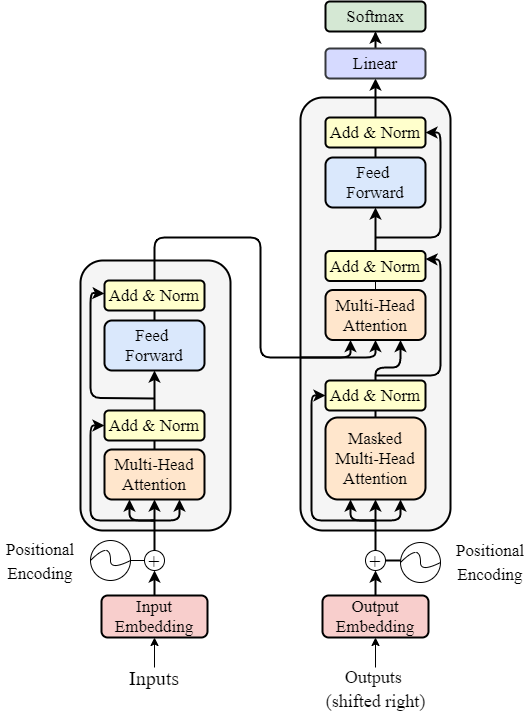




The Transformer follows this overall architecture using stacked self-attention and point-wise, fullyconnected layers for both the encoder and decoder, shown in the left and right halves of above Figure,respectively.



 **Encoder:**

 The encoder maps an input sequence of symbol representations  $X = (x_1, ... ,x_n)$ to a sequence of continuous representations $Z = (z_1, ... , z_n)$. Given Z, the decoder then generates an output
 sequence $(y1,...,ym)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.



First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.


Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, hid_dim. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

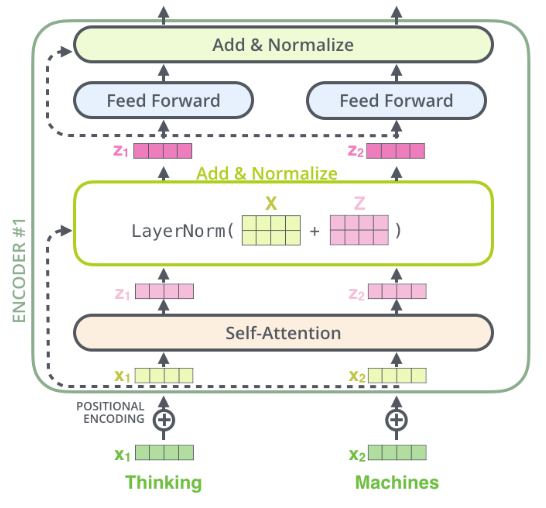

For the first encoder block after passing through the embedding layers
it is passed through the multi head self attention layer and dropout is applied.

Then the input is also passed as a residual connection and through a "normalization layer".

Then It is passed through a feed forward layer then again dropout,residual and normalization layer, the output of this layer is passed to the next encoder block.

**First Method of Implementing the transformer architecture:**

Note that in the second method of implementing the tranformers' architecture which is at the end of the notebook, I implemented the positional encoding and the scaled dot product attention too.

In [ ]:
# Class definition for the Encoder module
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=100):
        super().__init__()

        # Initialize device
        self.device = device

        # Token embedding layer
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)

        # Positional embedding layer
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        # List of encoder layers
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Scaling factor for positional encoding
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        """
        Forward pass of the Encoder module
        """
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        # Generate positional indices
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos = [batch size, src len]

        # Apply token embedding and scale by square root of hid_dim, then add positional encoding
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src = [batch size, src len, hid dim]

        # Pass source through each layer of the encoder
        for layer in self.layers:
            src = layer(src, src_mask)

        # src = [batch size, src len, hid dim]

        return src

This above code defines the `Encoder` class, which represents the encoder component of a Transformer model. Here's a breakdown of what it does:

1. **Class Definition**: Defines the `Encoder` class inheriting from `nn.Module`.
2. **Constructor (`__init__`)**: Initializes the encoder architecture and parameters.
   - Parameters:
     - `input_dim`: Dimensionality of the input vocabulary.
     - `hid_dim`: Dimensionality of the hidden layers.
     - `n_layers`: Number of encoder layers.
     - `n_heads`: Number of attention heads in multi-head attention.
     - `pf_dim`: Dimensionality of the feedforward layers.
     - `dropout`: Dropout probability.
     - `device`: Device to run the model on (e.g., CPU or GPU).
     - `max_length`: Maximum sequence length (default is 100).
   - Initializes embedding layers for token and positional embeddings.
   - Creates multiple encoder layers (`EncoderLayer`) based on the specified number of layers.
   - Initializes a dropout layer.
   - Initializes a scaling factor for the embeddings.
3. **Forward Method (`forward`)**: Defines the forward pass of the encoder.
   - Parameters:
     - `src`: Input tensor representing source sequences (batched tokenized sequences).
     - `src_mask`: Mask tensor to prevent the model from attending to padding tokens.
   - Retrieves the batch size and source sequence length.
   - Generates positional encodings based on the sequence length.
   - Applies token embeddings and scales them by the square root of the hidden dimension, then adds positional embeddings.
   - Passes the embedded sequences through each encoder layer.
   - Returns the encoded representations of the input sequences.

This `Encoder` class forms the backbone of the encoder in the Transformer architecture, handling token and positional embeddings, as well as multiple layers of encoder blocks.

**Encoder Layer:**

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the multi-head attention layer, then perform dropout on it, apply a residual connection and pass it through a Normalization layer. We then pass it through a position-wise feedforward layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers.

In [ ]:
# Class definition for the EncoderLayer module
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        # Layer normalization for self-attention
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        # Layer normalization for feedforward layer
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Multi-head self-attention layer
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)

        # Position-wise feedforward layer
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        """
        Forward pass of the EncoderLayer module
        """
        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]

        # Self-attention mechanism
        _src, _ = self.self_attention(src, src, src, src_mask)

        # Dropout, residual connection, and layer normalization for self-attention
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        # Position-wise feedforward mechanism
        _src = self.positionwise_feedforward(src)

        # Dropout, residual connection, and layer normalization for feedforward layer
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        return src

**Attention:**   
 An attention function can be described as mapping a query and a set of key-value pairs to an output,
 where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.


 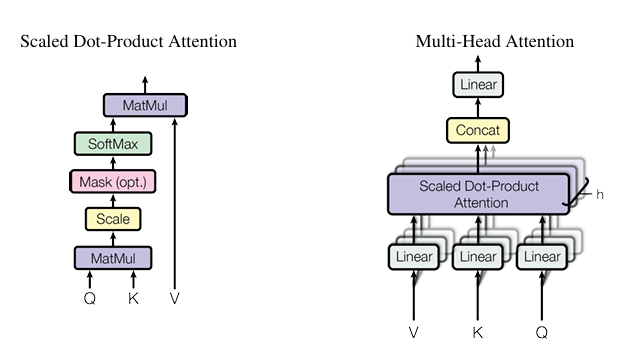

**Scaled Dot-Product Attention:**    
 We call our particular attention "Scaled Dot-Product Attention". The input consists ofqueries and keys of dimension $d_k$ , and values of dimension dv. We compute the dot products of the query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the values.
 In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:
$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$


**Mutli Head Attention Layer:**

 Instead of performing a single attention function with dmodel-dimensional keys, values and queries,we found it beneficial to linearly project the queries, keys and values h times with different, learned
 linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional output values. These are concatenated and once again projected, resulting in the final values, as
 depicted in above figure.
 Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.


$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$


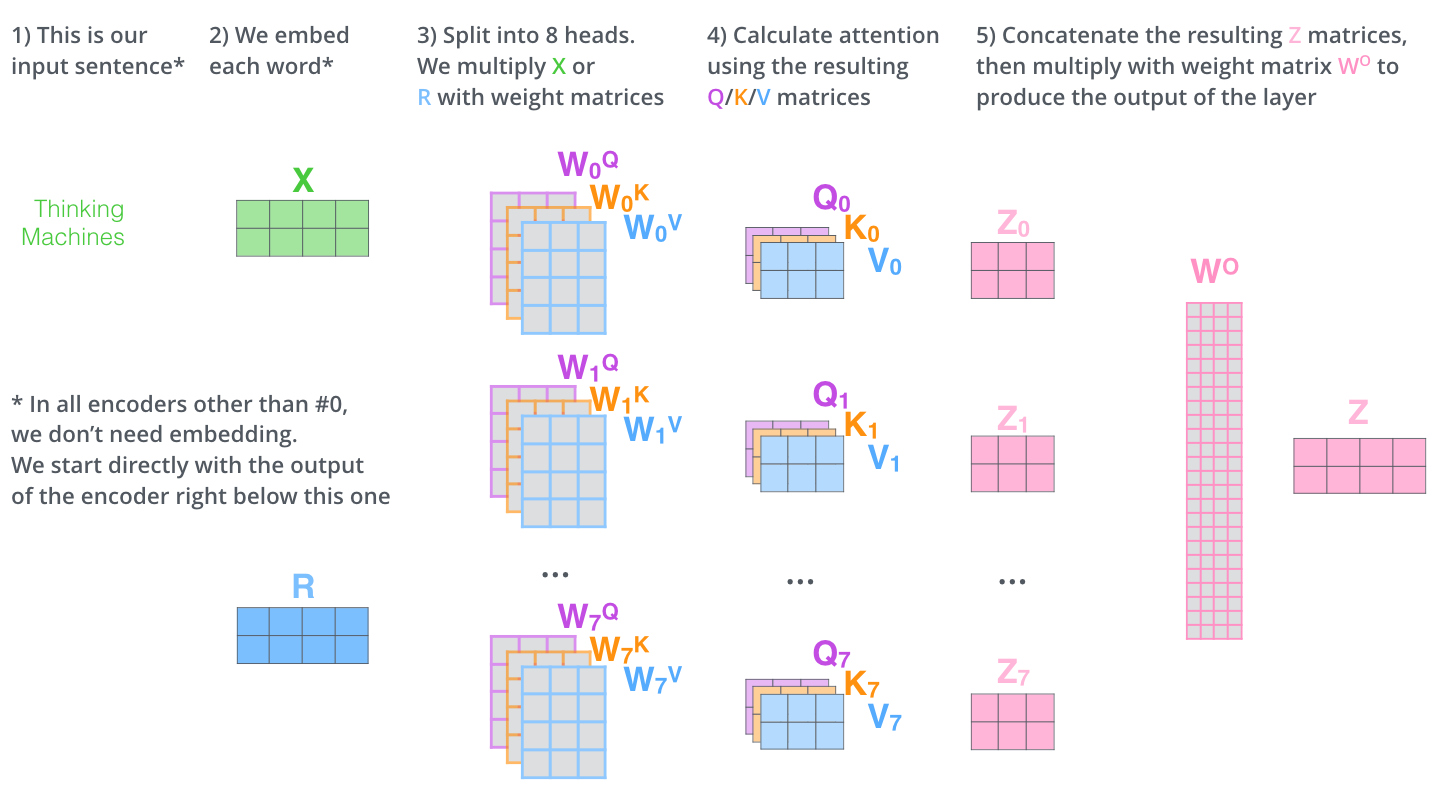





Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`.

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a [query len, key len] x [value len, head dim] batched matrix multiplication over the batch size and each head which provides the [batch size, n heads, query len, head dim] result.

In [ ]:
# Class definition for the MultiHeadAttentionLayer module
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # Assert condition to ensure hid_dim is divisible by n_heads
        assert hid_dim % n_heads == 0

        # Initialize attributes
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        # Linear transformations for queries, keys, and values
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Linear transformation for the output
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Scaling factor
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        """
        Forward pass of the MultiHeadAttentionLayer module
        """
        batch_size = query.shape[0]

        # Query, key, and value transformations
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head mechanism
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Energy calculation
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Attention calculation
        attention = torch.softmax(energy, dim = -1)

        # Weighted sum of values
        x = torch.matmul(self.dropout(attention), V)

        # Permute and reshape to original shape
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)

        # Linear transformation for output
        x = self.fc_o(x)

        return x, attention

**Position-wise Feedforward Layer:**

 In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
 connected feed-forward network, which is applied to each position separately and identically. This
 consists of two linear transformations with a ReLU activation in between.

 $FFN(x) = max(0,xW1 +b1)W2 +b2$


In [ ]:
# Class definition for the PositionwiseFeedforwardLayer module
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        """
        Constructor method for the PositionwiseFeedforwardLayer module
        """
        super().__init__()

        # Linear transformations
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of the PositionwiseFeedforwardLayer module
        In the forward method, the input tensor x undergoes the following operations:
        First, it passes through the fc_1 linear layer followed by the ReLU activation function (torch.relu). Dropout is applied to the result.
        Next, the output from the dropout layer is passed through the fc_2 linear layer to produce the final output tensor.
        """
        # Apply the first linear transformation followed by ReLU activation and dropout
        x = self.dropout(torch.relu(self.fc_1(x)))

        # Apply the second linear transformation
        x = self.fc_2(x)

        return x

**Decoder Layer:**

The decoder consists of a stack of three sublayers:

1) The first sublayer receives the previous output of the decoder stack, augments it with positional information, and implements multi-head self-attention over it. While the encoder is designed to attend to all words in the input sequence regardless of their position in the sequence, the decoder is modified to attend only to the preceding words. Hence, the prediction for a word at position can only depend on the known outputs for the words that come before it in the sequence. In the multi-head attention mechanism (which implements multiple, single attention functions in parallel), this is achieved by introducing a mask over the values produced by the scaled multiplication of matrices.

2)The second layer implements a multi-head self-attention mechanism similar to the one implemented in the first sublayer of the encoder. On the decoder side, this multi-head mechanism receives the queries from the previous decoder sublayer and the keys and values from the output of the encoder. This allows the decoder to attend to all the words in the input sequence.

3)The third layer implements a fully connected feed-forward network, similar to the one implemented in the second sublayer of the encoder.
Furthermore, the three sublayers on the decoder side also have residual connections around them and are succeeded by a normalization layer.

Positional encodings are also added to the input embeddings of the decoder in the same manner as previously explained for the encoder.

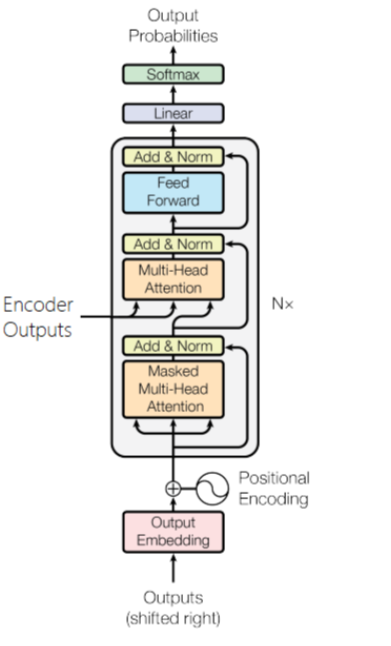

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`.

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers.

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        #Token Embedding Layer
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        # Positional Embedding Layer
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])
       # Output Fully Connected Layer
        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
       # Scaling Factor for Embeddings
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]
        # Pass through Decoder Layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

In [ ]:
# Class definition for the DecoderLayer module
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        """
        Constructor method for the DecoderLayer module

        Args:
        - hid_dim (int): The input dimensionality of the hidden layer.
        - n_heads (int): The number of attention heads.
        - pf_dim (int): The dimensionality of the intermediate (feedforward) layer.
        - dropout (float): The dropout probability to apply after each sub-layer..
        """
        super().__init__()

        # Layer normalization for self-attention, encoder-decoder attention, and feedforward layers
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Self-attention and encoder-decoder attention layers
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)

        # Positionwise feedforward layer
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Forward pass of the DecoderLayer module

        Args:
        - trg (torch.Tensor): The input tensor of shape (batch_size, trg_len, hid_dim).
        - enc_src (torch.Tensor): The encoded source tensor of shape (batch_size, src_len, hid_dim).
        - trg_mask (torch.Tensor): The mask tensor for the target sequence.
        - src_mask (torch.Tensor): The mask tensor for the source sequence.

        Returns:
        - trg (torch.Tensor): The output tensor of shape (batch_size, trg_len, hid_dim).
        - attention (torch.Tensor): The attention tensor of shape (batch_size, n_heads, trg_len, src_len).
        """
        # Self-attention sub-layer
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # Encoder-decoder attention sub-layer
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # Positionwise feedforward sub-layer
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention

**Creating a Seq2Seq Model:**   
After creating the Encoder and Decoder stacks and understanding how to mask the source and target inputs. We can now connect all of them and create a sequence to sequence model which generates one word per time step till the end special token is reached.

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape [batch size, n heads, seq len, seq len].

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of [1, 0, 0, 0, 0] which means it can only look at the first target token. The second target token has a mask of [1, 1, 0, 0, 0] which it means it can look at both the first and second target tokens.

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [ ]:
# Class definition for the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        """
        Constructor method for the Seq2Seq model

        Args:
        - encoder (nn.Module): The encoder module.
        - decoder (nn.Module): The decoder module.
        - src_pad_idx (int): The index for padding tokens in the source sequence.
        - trg_pad_idx (int): The index for padding tokens in the target sequence.
        """
        super().__init__()

        # Initialization of encoder, decoder, and other attributes
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """
        Creates a mask tensor for the source sequence

        Args:
        - src (torch.Tensor): The source tensor of shape (batch_size, src_len).

        Returns:
        - src_mask (torch.Tensor): The mask tensor for the source sequence.
        """

        # Check for padding tokens in the source sequence
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask = [batch size, 1, 1, src len]
        return src_mask

    def make_trg_mask(self, trg):
        """
        Creates a mask tensor for the target sequence

        Args:
        - trg (torch.Tensor): The target tensor of shape (batch_size, trg_len).

        Returns:
        - trg_mask (torch.Tensor): The mask tensor for the target sequence.
        """

        # Check for padding tokens in the target sequence
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]

        # Create a lower triangular mask for the target sequence
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        # trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        """
        Forward pass of the Seq2Seq model

        Args:
        - src (torch.Tensor): The source tensor of shape (batch_size, src_len).
        - trg (torch.Tensor): The target tensor of shape (batch_size, trg_len).

        Returns:
        - output (torch.Tensor): The output tensor of shape (batch_size, trg_len, output_dim).
        - attention (torch.Tensor): The attention tensor of shape (batch_size, n_heads, trg_len, src_len).
        """

        # Create masks for source and target sequences
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        # Encode the source sequence
        enc_src = self.encoder(src, src_mask)

        # enc_src = [batch size, src len, hid dim]

        # Decode the target sequence using the encoded source sequence
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]

        return output, attention

**Training the Seq2Seq Model:**


In [ ]:
# Define the input and output dimensions based on the vocabulary sizes
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

# Define the hidden dimension size
HID_DIM = 256

# Define the number of layers for the encoder and decoder
ENC_LAYERS = 3
DEC_LAYERS = 3

# Define the number of attention heads for the encoder and decoder
ENC_HEADS = 8
DEC_HEADS = 8

# Define the feedforward dimension size for the encoder and decoder
ENC_PF_DIM = 512
DEC_PF_DIM = 512

# Define the dropout probability for the encoder and decoder
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# Initialize the encoder module with the specified parameters
enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

# Initialize the decoder module with the specified parameters
dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

In [ ]:
# Get the index of the padding token for the source and target vocabularies
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# Initialize the Seq2Seq model with the encoder, decoder, and padding indices, and move it to the specified device (GPU or CPU)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,085 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here:

In [ ]:
# Define a function to initialize the weights of a neural network module
def initialize_weights(m):
    # Check if the module has a weight attribute and if the weight has more than one dimension
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        # Apply Xavier uniform initialization to the weight data
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    """
    Train the model on the given iterator data, using the specified optimizer and criterion.

    Args:
    - model: The PyTorch model to be trained.
    - iterator: The data iterator providing batches of training data.
    - optimizer: The optimizer to update the model's parameters.
    - criterion: The loss criterion used to calculate the loss.
    - clip: Value for gradient clipping to prevent exploding gradients.

    Returns:
    - epoch_loss: Average loss over the entire dataset for one epoch.
    """
    model.train()  # Set the model to train mode
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.german                      # Get German source sentences from the batch
        trg = batch.english[:, :-1]             # Get English target sentences from the batch, excluding the <eos> token
        optimizer.zero_grad()                   # Zero the gradients
        output, _ = model(src, trg)             # Forward pass
        output_dim = output.shape[-1]           # Get the output dimension
        output = output.contiguous().view(-1, output_dim)  # Reshape the output for loss calculation
        trg = batch.english[:, 1:].contiguous().view(-1)  # Flatten the target sentences, excluding the <sos> token
        loss = criterion(output, trg)           # Calculate the loss
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm(model.parameters(), clip)  # Clip gradients to prevent explosion
        optimizer.step()                        # Update the parameters
        epoch_loss += loss.item()               # Accumulate the loss

    return epoch_loss / len(iterator)  # Return the average loss for the epoch

In [ ]:
def evaluate(model, iterator, criterion):
    """
    Evaluate the model's performance on the given iterator data using the specified criterion.

    Args:
    - model: The PyTorch model to be evaluated.
    - iterator: The data iterator providing batches of evaluation data.
    - criterion: The loss criterion used to calculate the loss.

    Returns:
    - epoch_loss: Average loss over the entire dataset for one epoch.
    """
    model.eval()  # Set the model to evaluation mode
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.german           # Get German source sentences from the batch
            trg = batch.english[:, :-1]  # Get English target sentences from the batch, excluding the <eos> token
            output, _ = model(src, trg)  # Forward pass
            output_dim = output.shape[-1]  # Get the output dimension
            output = output.contiguous().view(-1, output_dim)  # Reshape the output for loss calculation
            trg = batch.english[:, 1:].contiguous().view(-1)  # Flatten the target sentences, excluding the <sos> token
            loss = criterion(output, trg)  # Calculate the loss
            epoch_loss += loss.item()      # Accumulate the loss

    return epoch_loss / len(iterator)  # Return the average loss for the entire dataset for one epoch

<ipython-input-33-766ccbc61183>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)  # Clip gradients to prevent explosion


Epoch: 01
	Train Loss: 4.232 | Train PPL:  68.824
	 Val. Loss: 3.079 |  Val. PPL:  21.743
Epoch: 02
	Train Loss: 2.817 | Train PPL:  16.732
	 Val. Loss: 2.377 |  Val. PPL:  10.772
Epoch: 03
	Train Loss: 2.235 | Train PPL:   9.349
	 Val. Loss: 2.033 |  Val. PPL:   7.636
Epoch: 04
	Train Loss: 1.886 | Train PPL:   6.592
	 Val. Loss: 1.854 |  Val. PPL:   6.386
Epoch: 05
	Train Loss: 1.639 | Train PPL:   5.151
	 Val. Loss: 1.775 |  Val. PPL:   5.900
Epoch: 06
	Train Loss: 1.448 | Train PPL:   4.255
	 Val. Loss: 1.702 |  Val. PPL:   5.483
Epoch: 07
	Train Loss: 1.296 | Train PPL:   3.656
	 Val. Loss: 1.671 |  Val. PPL:   5.319
Epoch: 08
	Train Loss: 1.168 | Train PPL:   3.215
	 Val. Loss: 1.664 |  Val. PPL:   5.279


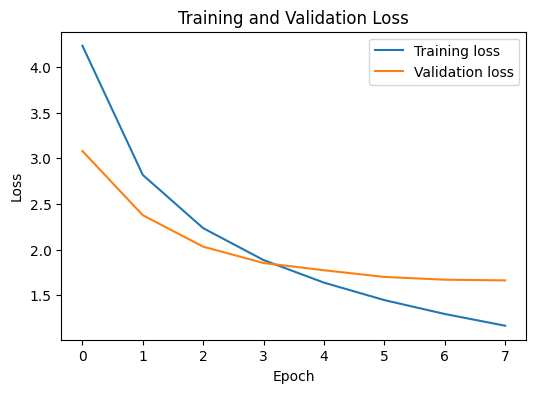

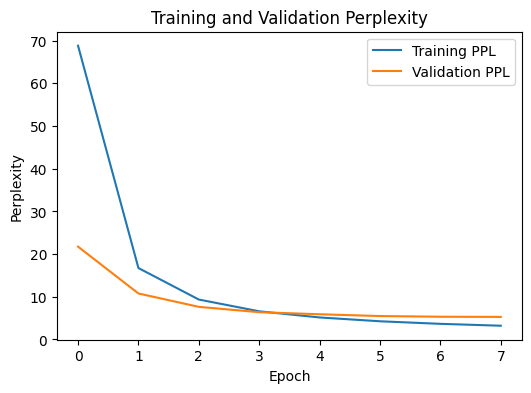

In [ ]:
# Training iterations
N_EPOCHS = 8  # Number of training epochs
CLIP = 1  # Gradient clipping threshold
best_valid_loss = float('inf')  # Initialize best validation loss to infinity

train_losses = []  # List to store training losses for each epoch
valid_losses = []  # List to store validation losses for each epoch
train_ppls = []  # List to store training perplexity for each epoch
valid_ppls = []  # List to store validation perplexity for each epoch

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)  # Train the model
    valid_loss = evaluate(model, valid_iterator, criterion)  # Evaluate the model on validation set

    train_ppl = math.exp(train_loss)  # Calculate training perplexity
    valid_ppl = math.exp(valid_loss)  # Calculate validation perplexity

    if valid_loss < best_valid_loss:  # Update best validation loss and save the model checkpoint if validation loss improves
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Tmulti30k/checkpointss/model.pt')

    # Print training and validation loss and perplexity for each epoch
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')
    print('='*50)

    # Append training and validation losses and perplexities to their respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)

# Plot training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation perplexity
plt.figure(figsize=(6, 4))
plt.plot(train_ppls, label='Training PPL')
plt.plot(valid_ppls, label='Validation PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.show()

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load( '/content/drive/MyDrive/Tmulti30k/checkpointss/model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.713 | Test PPL:   5.546 |


**Perplexity:**   
Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Perplexity (PPL) is one of the most common metrics for evaluating language models. .

Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. If we have a tokenized
sequence $X = (x_0, x_1, \dots, x_t)$, then the perplexity of $X$ is,

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

where $\log p_\theta (x_i|x_{<i})$ is the log-likelihood of the ith token conditioned on the preceding tokens $x_{<i}$ according to our model. Intuitively, it can be thought of as an evaluation of the model's ability to predict uniformly among the set of specified tokens in a corpus. Importantly, this means that the tokenization procedure has a direct impact on a model's perplexity which should always be taken into consideration when comparing different models.

This is also equivalent to the exponentiation of the cross-entropy between the data and model predictions.


Perplexity is usually used only to determine how well a model has learned the training set. Other metrics like BLEU, etc., are used on the test set to measure test performance and we eill use BLEU Score in the next parts too.

As we see in above plots the valiadtion loss and validatio PPL are decreasing across epochs;  a decreasing validation loss indicates that the model is generalizing well to unseen data, as it is also reducing its error on the validation set. This suggests that the model is converging towards an optimal solution and becoming better at making predictions and a decreasing validation perplexity suggests that the model is generalizing well to unseen data and improving its ability to predict the next word in a sequence accurately.

The decreasing trend in both losses and perplexities across epochs implies that the model is learning meaningful patterns from the training data and successfully generalizing to new data

**Inference:**

Now we can make translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    """
    Translate a source sentence to a target language using a trained sequence-to-sequence model.

    Args:
    - sentence (str or List[str]): The source sentence to be translated. It can be a string or a list of tokens.
    - src_field (Field): The source language field object, containing vocabulary and other properties.
    - trg_field (Field): The target language field object, containing vocabulary and other properties.
    - model (nn.Module): The trained sequence-to-sequence model for translation.
    - device (torch.device): The device to perform computations on (e.g., 'cuda' or 'cpu').
    - max_len (int): The maximum length of the translated sequence.

    Returns:
    - trg_tokens (List[str]): The list of tokens representing the translated sentence.
    - attention (torch.Tensor): The attention weights of the translation.
    """
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input sentence if it's a string
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in tokenize_de(sentence)]  # Tokenize German text
    else:
        tokens = [token.lower() for token in sentence]  # Otherwise, use the provided list of tokens

    # Add start-of-sequence (SOS) and end-of-sequence (EOS) tokens
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # Convert tokens to indexes using the source field's vocabulary
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    # Convert indexes to a PyTorch tensor and unsqueeze to add batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # Create source mask to ignore padding tokens
    src_mask = model.make_src_mask(src_tensor)

    # Pass the source tensor through the encoder
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # Initialize target indexes with the index of the start-of-sequence token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # Generate target tokens one by one until reaching the maximum length or end-of-sequence token
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # Get the predicted token (word) with the highest probability
        pred_token = output.argmax(2)[:,-1].item()

        # Append the predicted token to the list of target indexes
        trg_indexes.append(pred_token)

        # Check if the predicted token is the end-of-sequence token
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # Convert target indexes back to tokens using the target field's vocabulary
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # Return the list of target tokens (excluding the start-of-sequence token) and the attention weights
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [ ]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    """
    Display the attention weights for each head in a multi-head attention mechanism.

    Args:
    - sentence (List[str]): The source sentence tokens.
    - translation (List[str]): The translated sentence tokens.
    - attention (torch.Tensor): The attention weights of shape (batch_size, n_heads, trg_len, src_len).
    - n_heads (int): The number of attention heads.
    - n_rows (int): The number of rows in the subplot grid.
    - n_cols (int): The number of columns in the subplot grid.
    """
    assert n_rows * n_cols == n_heads  # Ensure the number of subplots matches the number of attention heads

    # Create a figure with specified size
    fig = plt.figure(figsize=(15, 25))

    # Loop over each attention head
    for i in range(n_heads):
        # Add a subplot to the figure
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # Extract attention weights for the current head and convert to numpy array
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        # Plot the attention matrix
        cax = ax.matshow(_attention, cmap='bone')

        # Set tick labels and rotation for source and target sequences
        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
        ax.set_yticklabels([''] + translation)

        # Set major locators for x and y axes
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Show the plot
    plt.show()

First, we'll get an example from the training set.

In [ ]:
# Get the source (German) and target (English) sentences from the training data
example_idx = 9
src = vars(train_data.examples[example_idx])['german']
trg = vars(train_data.examples[example_idx])['english']

print(f'src = {src}')  # Print the source sentence
print(f'trg = {trg}')  # Print the target sentence

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
# Translate the source sentence using the translate_sentence function
# It returns the predicted target sentence and the attention weights
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')  # Print the predicted target sentence

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

Below `display_attention` function plots the attention maps generated by the decoder block. These attention maps illustrate how the model attends to different parts of the source sentence (German) when generating the translation (English). Each subplot in the visualization represents the attention distribution for a single head in the multi-head attention mechanism of the decoder block. Therefore, the function provides insights into which words or phrases in the source sentence are most relevant at each decoding step during the translation process.

<ipython-input-38-b1a5d0fc20bf>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
<ipython-input-38-b1a5d0fc20bf>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


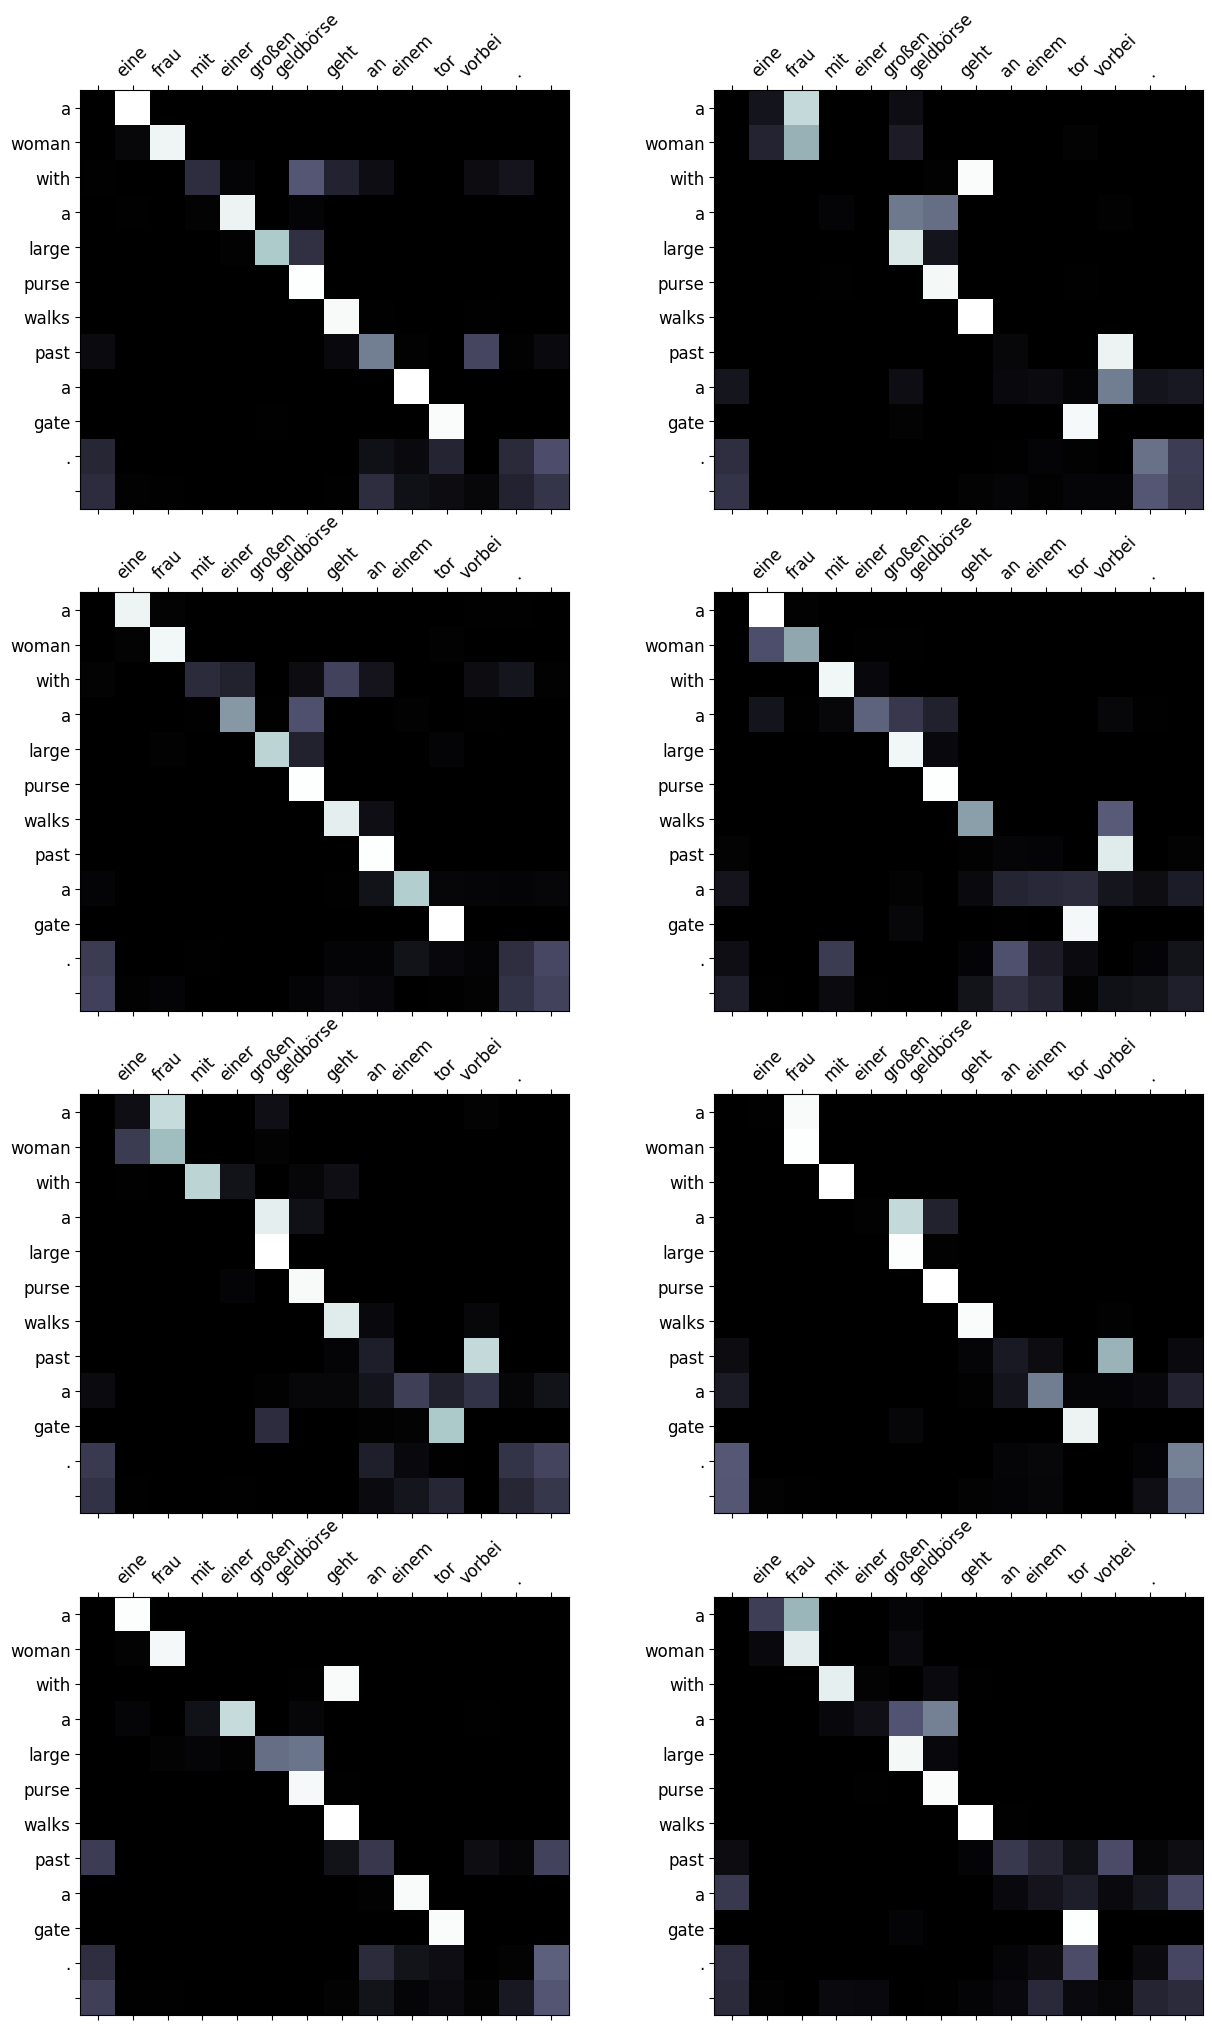

In [ ]:
#visualizes the attention weights generated by the model during the translation process.
display_attention(src, translation, attention)

The above function creates a visualization of the attention weights for each head of the multi-head attention mechanism.

It displays a grid of subplots, where each subplot represents the attention distribution for a single head.

Each subplot shows the attention weights as a heatmap, where darker shades indicate higher attention weights.

The source sentence (German) is displayed along the x-axis, and the translated target sentence (English) is displayed along the y-axis.

Next, let's get an example the model has not been trained on from the validation set.

In [ ]:
example_idx = 36

src = vars(valid_data.examples[example_idx])['german']
trg = vars(valid_data.examples[example_idx])['english']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'sitzt', 'an', 'einer', 'dunklen', 'bar', '.']
trg = ['a', 'woman', 'sits', 'at', 'a', 'dark', 'bar', '.']


The model translates it by switching *sits* to just *sitting*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'sitting', 'at', 'a', 'dark', 'bar', '.', '']


Again, some heads pay full attention to "eine" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>`( ' ' )tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

<ipython-input-38-b1a5d0fc20bf>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
<ipython-input-38-b1a5d0fc20bf>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


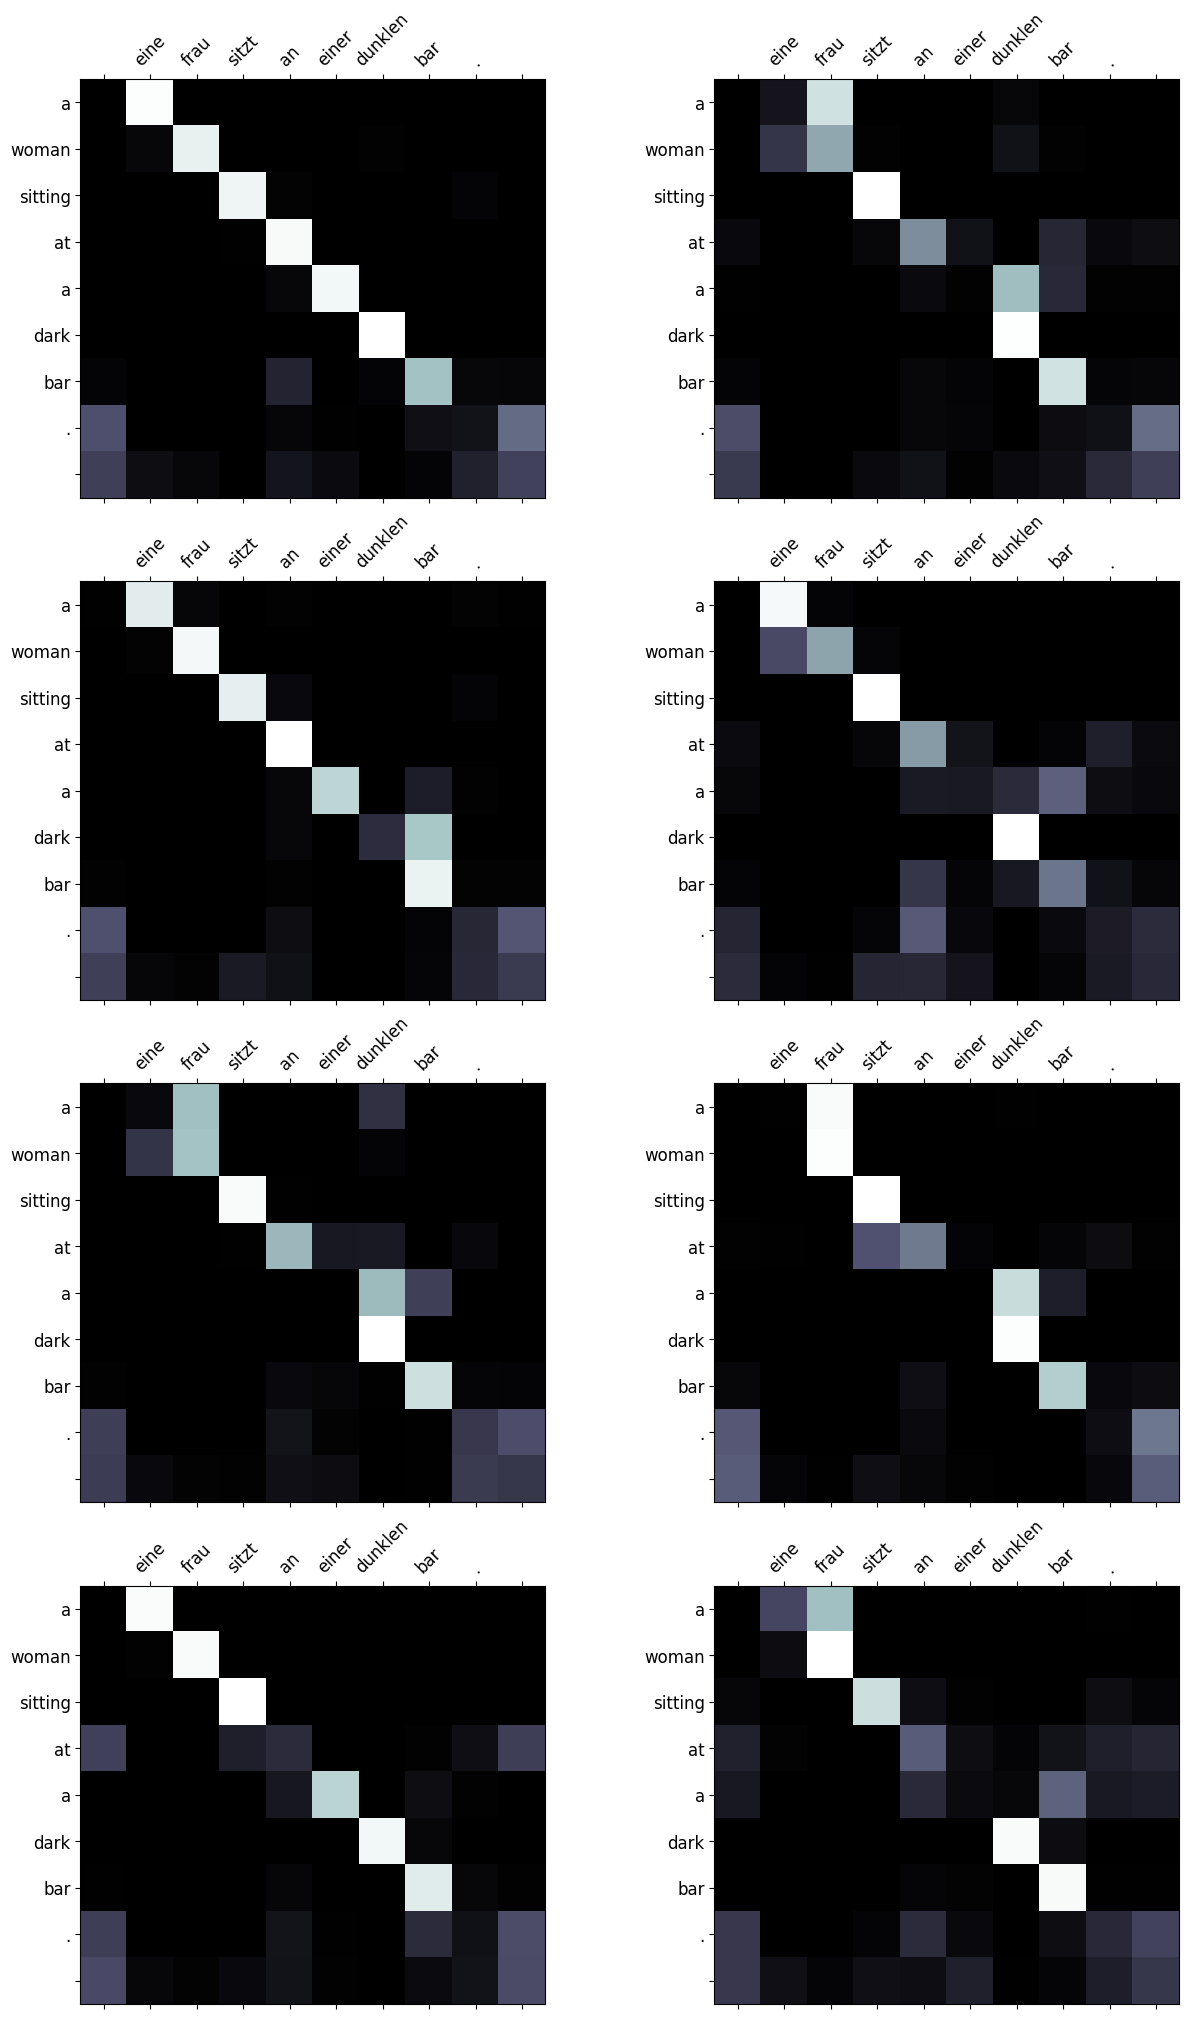

In [ ]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [ ]:
example_idx = 26

src = vars(test_data.examples[example_idx])['german']
trg = vars(test_data.examples[example_idx])['english']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'in', 'einem', 'pinken', 'pulli', 'und', 'einer', 'schürze', 'putzt', 'einen', 'tisch', 'mit', 'einem', 'schwamm', '.']
trg = ['a', 'woman', 'in', 'a', 'pink', 'sweater', 'and', 'an', 'apron', ',', 'cleaning', 'a', 'table', 'with', 'a', 'sponge', '.']


A perfect translation!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'in', 'a', 'pink', 'sweater', 'and', 'apron', 'is', 'cleaning', 'a', 'table', 'with', 'a', 'sponge', '.', '']


<ipython-input-38-b1a5d0fc20bf>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
<ipython-input-38-b1a5d0fc20bf>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


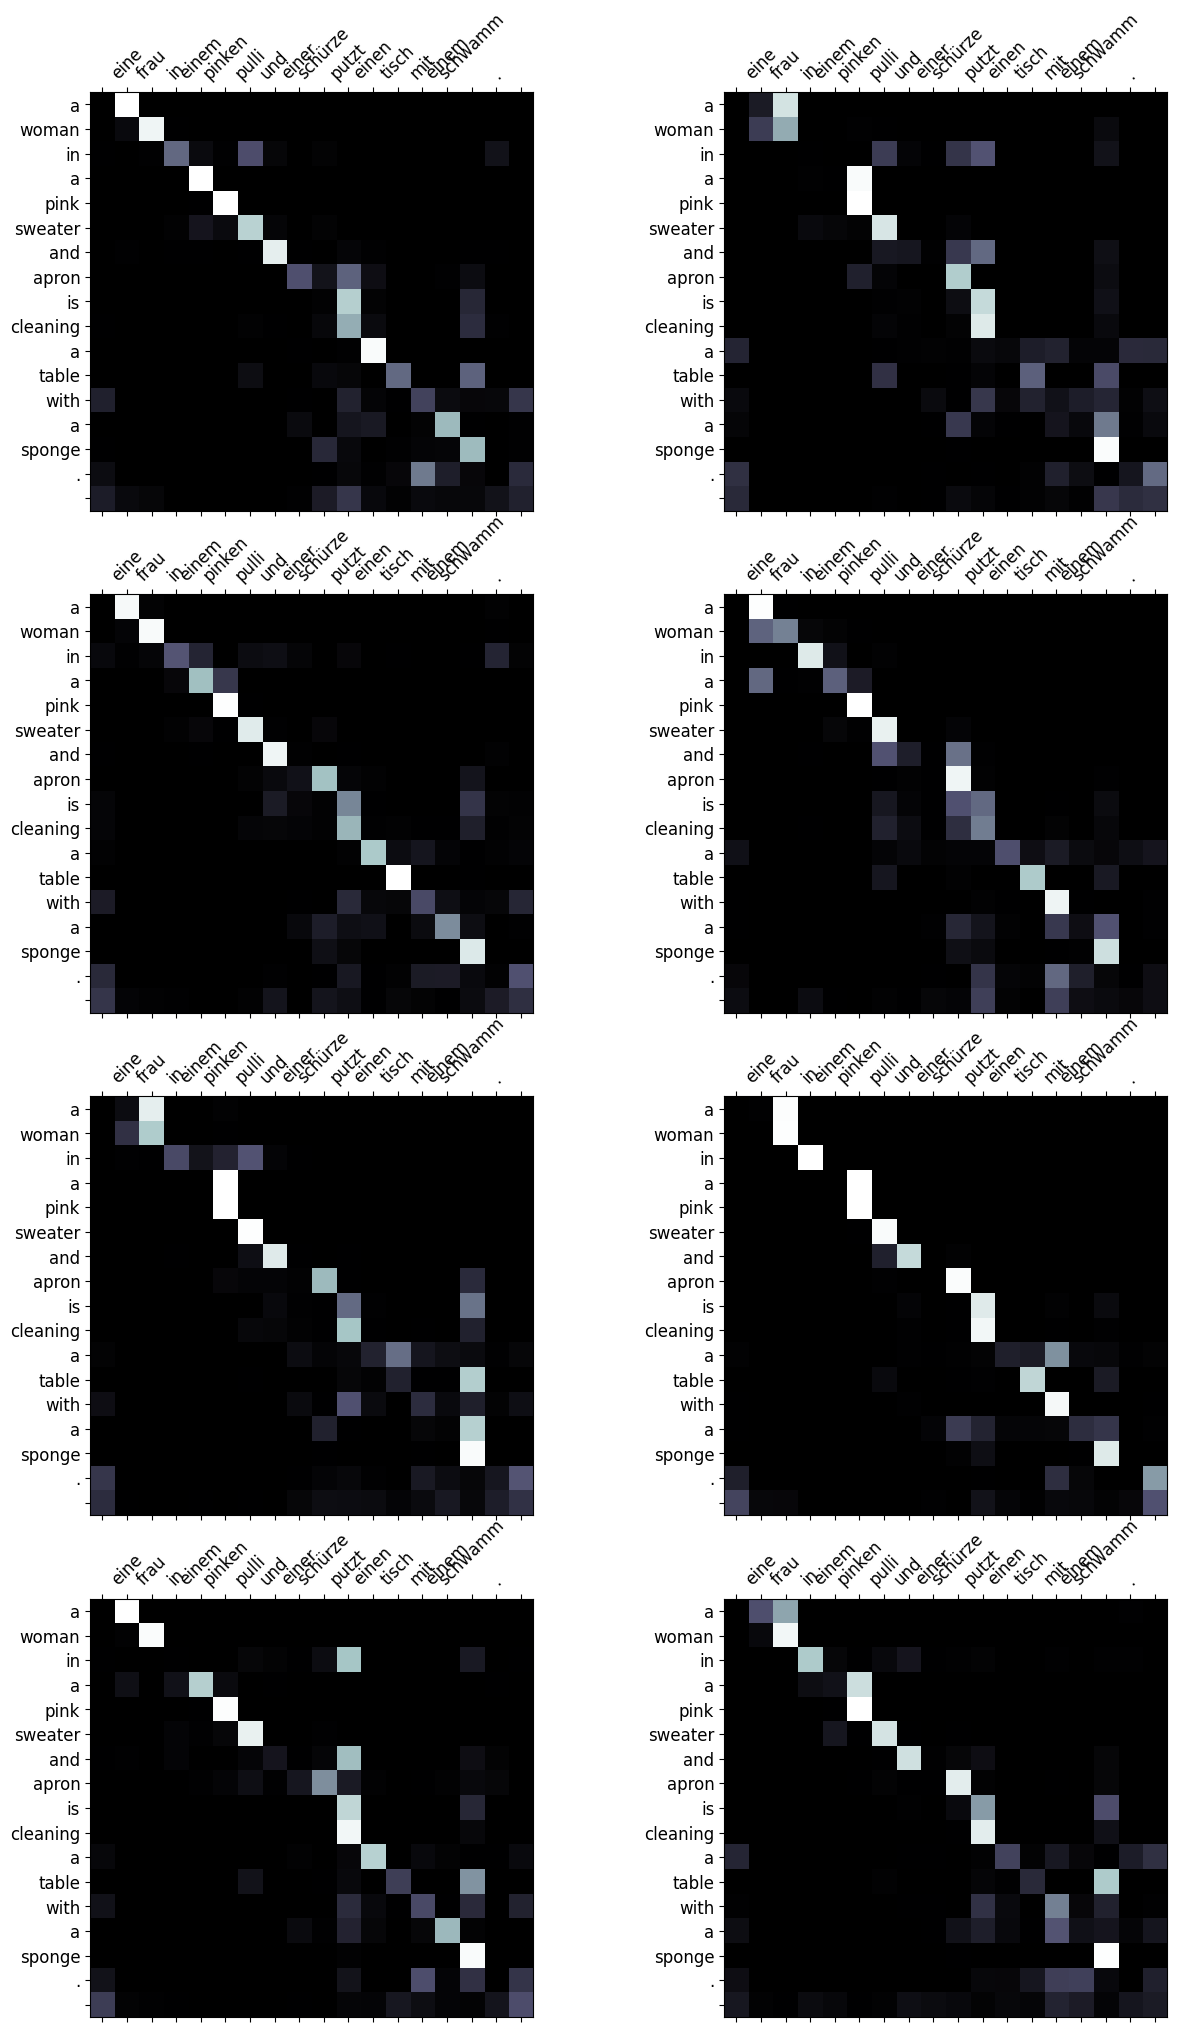

In [ ]:
display_attention(src, translation, attention)

**Calculating BLEU Score:**


In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    """
    Calculate the BLEU score for a dataset.

    Args:
    - data (torchtext.data.Dataset): The dataset containing source and target sentences.
    - src_field: The source field.
    - trg_field: The target field.
    - model (nn.Module): The translation model.
    - device (torch.device): The device to perform computations on.
    - max_len (int, optional): The maximum length of the generated translation sequence.

    Returns:
    - bleu_score (float): The BLEU score for the dataset.
    """
    trgs = []          # List to store true target sentences
    pred_trgs = []     # List to store predicted target sentences

    for datum in data:      # Iterate over each example in the dataset
        src = vars(datum)['german']   # Extract German (source) sentence from the current example
        trg = vars(datum)['english']  # Extract English (target) sentence from the current example

        # Generate translation for the source sentence using the provided model
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        # Remove the <eos> token from the predicted translation
        pred_trg = pred_trg[:-1]

        # Append the true and predicted target sentences to the respective lists
        pred_trgs.append(pred_trg)
        trgs.append([trg])

    # Calculate the BLEU score between the predicted and true target sentences
    return bleu_score(pred_trgs, trgs)

In [ ]:
# Calculate BLEU score for the test dataset
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.67


 **BLEU (Bilingual Evaluation Understudy) score:**   
 The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence and indicates how similar the candidate text is to the reference texts, with values closer to one representing more similar texts.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.


 We get a BLEU score of 35.67, while achieving a BLEU score of 35.67 demonstrates moderate success in machine translation, there is still considerable room for improvement.

**Second Method for implementing the transformer architecture:**

In [ ]:
class ScaledDotAttention(nn.Module):
    def __init__(self):
        super(ScaledDotAttention, self).__init__()

    def forward(self, q, k, v, mask):
        # q, k, v: Query, Key, and Value matrices
        # mask: Mask tensor for masking padded positions

        # shape: [n_batch, seq_len, d_k]
        query = q
        key = k
        value = v

        # Calculate scaled dot-product attention scores
        # shape: [n_batch, seq_len, seq_len]
        score = torch.matmul(query, key.transpose(-2,-1))
        score = score / math.sqrt(key.size(-1))  # Scaling factor

        # Apply mask to handle padded positions (if mask is provided)
        if mask is not None:
            # Masking positions where mask is 0 with a large negative value (-1e9)
            score = score.masked_fill(mask==0, -1e9)

        # Apply softmax to obtain attention probabilities
        # shape: [n_batch, seq_len, seq_len]
        prob = nn.Softmax(dim=-1)(score)

        # Compute the weighted sum of values using attention probabilities
        # shape: [n_batch, seq_len, d_k]
        out = torch.matmul(prob, value)

        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_embed, h, device):
        """
        Constructor method for the MultiHeadAttention module.

        Args:
        - d_model (int): The dimensionality of the model.
        - d_embed (int): The dimensionality of the input embeddings.
        - h (int): The number of attention heads.
        - device (torch.device): The device for computations.
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.d_embed = d_embed
        self.h = h

        self.Q = nn.Linear(d_embed, d_model).to(device)
        self.K = nn.Linear(d_embed, d_model).to(device)
        self.V = nn.Linear(d_embed, d_model).to(device)

        self.self_attention = ScaledDotAttention()

        self.out_fc = nn.Linear(d_model, d_embed).to(device)

    def forward(self, q, k, v, mask=None):
        """
        Forward method for the MultiHeadAttention module.

        Args:
        - q (torch.Tensor): The query tensor of shape (n_batch, seq_len, d_embed).
        - k (torch.Tensor): The key tensor of shape (n_batch, seq_len, d_embed).
        - v (torch.Tensor): The value tensor of shape (n_batch, seq_len, d_embed).
        - mask (torch.Tensor): The mask tensor for masking attention scores (optional).

        Returns:
        - out (torch.Tensor): The output tensor of shape (n_batch, seq_len, d_embed).
        """

        # shape : [n_batch, seq_len, d_embed] -> [n_batch, seq_len, d_model)
        query = self.Q(q)
        key = self.K(k)
        value = self.V(v)

        n_batch = query.shape[0]

        # shape : [n_batch, self.h, seq_len, d_k]
        query = self.split(query)
        key = self.split(key)
        value = self.split(value)


        # shape : [n_batch, self.h, seq_len, d_k]
        out = self.self_attention(query,key,value, mask)
        # shape : [n_batch, seq_len, self.h, d_k]
        out = out.transpose(1,2)
        # shape : [n_batch, seq_len, d_model]
        out = out.contiguous().view(n_batch, -1, self.d_model)
        # shape : [n_batch, seq_len, d_embed]
        out = self.out_fc(out)
        return out

    def split(self, tensor):
        """
        Splits the tensor into multiple heads for multi-head attention.

        Args:
        - tensor (torch.Tensor): The input tensor of shape (n_batch, seq_len, d_model).

        Returns:
        - out (torch.Tensor): The tensor split into multiple heads.
        """

        # tensor_shape : [n_batch, seq_len, d_model]
        n_batch, seq_len, d_model = tensor.shape

        # Divide d_model into h parts.
        # shape : [n_batch, seq_len, h, d_k]
        out = tensor.view(n_batch, seq_len, self.h, d_model // self.h)
        # shape : [n_batch, h, seq_len, d_k]
        # Transpose the tensor to perform matrix operations based on the last [seq_len, d_k]
        # when calculating self attention.
        out = out.transpose(1,2)
        return out

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, device, d_model=512, d_ff= 2048, drop_prob=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff).to(device)
        self.linear2 = nn.Linear(d_ff, d_model).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = drop_prob).to(device)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, device, eps=1e-12):
        """
        Constructor method for the LayerNorm module.

        Args:
        - d_model (int): The dimensionality of the model.
        - device (torch.device): The device for computations.
        - eps (float): A small value added to the denominator for numerical stability.
        """
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model)).to(device)
        self.beta = nn.Parameter(torch.zeros(d_model)).to(device)
        self.eps = eps

    def forward(self, x):
        """
        Forward method for the LayerNorm module.

        Args:
        - x (torch.Tensor): The input tensor of shape (batch_size, seq_len, d_model).

        Returns:
        - out (torch.Tensor): The output tensor of shape (batch_size, seq_len, d_model).
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.beta
        return out

let's break down the above code step by step:

1. **Class Definition**:
    - The code defines a class named `LayerNorm`, which is a subclass of `nn.Module`. This class represents a layer normalization module.

2. **Constructor Method (`__init__`)**:
    - Parameters:
        - `d_model`: It represents the dimensionality of the input tensor.
        - `device`: It specifies the device (CPU or GPU) on which the computations will be performed.
        - `eps`: It's a small value added to the denominator for numerical stability. Default value is set to `1e-12`.
    - Operations:
        - Initializes learnable parameters `gamma` and `beta`, both of size `d_model`, initialized with ones and zeros respectively.
        - Stores `eps` as an attribute of the instance.

3. **Forward Method (`forward`)**:
    - Parameters:
        - `x`: The input tensor of shape `(batch_size, seq_len, d_model)`.
    - Operations:
        - Computes the mean and standard deviation along the last dimension (`-1`) of the input tensor `x`.
        - Normalizes the input tensor `x` using layer normalization formula:
          ```
          out = (x - mean) / (std + self.eps)
          ```
          where `mean` and `std` are the mean and standard deviation respectively.
        - Scales the normalized tensor by `gamma` and shifts it by `beta`, where both are learnable parameters.
        - Returns the normalized tensor `out`.

4. **Explanation**:
    - Layer normalization is applied along the last dimension of the input tensor. This allows each feature (or channel) to be normalized independently.
    - The `gamma` parameter scales the normalized values, while the `beta` parameter shifts them. This helps the model learn the optimal normalization for each feature.
    - Layer normalization helps in stabilizing the training process by reducing the internal covariate shift and allows for faster convergence during training.

5. **Device Handling**:
    - The `gamma` and `beta` parameters are moved to the specified device (`device`) using `.to(device)` method. This ensures that the parameters are stored and updated on the specified device.

In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self, d_embed, vocab, device, max_seq_len=5000):
        super(TransformerEmbedding, self).__init__()
        # self.embedding = nn.Sequential(
        #     Embedding(d_embed=d_embed, vocab=vocab, device=device),
        #     PositionalEncoding(d_embed=d_embed, device=device)
        # )
        self.emb = Embedding(d_embed=d_embed, vocab=vocab, device=device)
        self.pos_emb = PositionalEncoding(d_embed=d_embed, device=device)
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        emb = self.emb(x)
        pos_emb = self.pos_emb(x)
        return self.dropout(emb + pos_emb)

In [ ]:
# Class Definition
class Embedding(nn.Module):
    # Constructor Method
    def __init__(self, d_embed, vocab, device):
        # Attributes Initialization
        super(Embedding, self).__init__()
        self.vocab = vocab
        self.d_embed = d_embed
        self.device = device
        # Embedding Layer Initialization
        self.embedding = nn.Embedding(len(vocab), d_embed).to(self.device)

    # Forward Method
    def forward(self, x):
        # Retrieve Embeddings and Scale
        out = self.embedding(x) * math.sqrt(self.d_embed)
        return out

let's break down the above code:

1. **Class Definition**:
    - The code defines a class named `Embedding`, which is a subclass of `nn.Module`. This class represents an embedding layer.

2. **Constructor Method (`__init__`)**:
    - Parameters:
        - `d_embed`: It represents the dimensionality of the embedding vectors.
        - `vocab`: It represents the vocabulary object, typically obtained from the text data.
        - `device`: It specifies the device (CPU or GPU) on which the computations will be performed.
    - Operations:
        - Initializes attributes:
            - `vocab`: Stores the vocabulary object.
            - `d_embed`: Stores the dimensionality of the embedding vectors.
            - `device`: Stores the device on which the computations will be performed.
        - Initializes the embedding layer (`nn.Embedding`) with the size of the vocabulary and the specified embedding dimension. Moves the embedding layer to the specified device.

3. **Forward Method (`forward`)**:
    - Parameters:
        - `x`: The input tensor containing indices of tokens to be embedded.
    - Operations:
        - Retrieves the embeddings for the input indices from the embedding layer.
        - Scales the embeddings by multiplying with the square root of the embedding dimension (`math.sqrt(self.d_embed)`).
        - Returns the scaled embeddings.

4. **Explanation**:
    - The `Embedding` class encapsulates the embedding layer functionality.
    - During initialization, it creates an embedding layer based on the vocabulary size and embedding dimension.
    - During the forward pass, it looks up the embeddings for input token indices and scales them by a factor of square root of embedding dimension. This scaling factor is typically used to prevent the gradients from vanishing or exploding during training.

5. **Device Handling**:
    - The embedding layer is moved to the specified device (`device`) using `.to(self.device)` method. This ensures that the embedding layer is stored and updated on the specified device.


**Positional Encoding:**  
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
 bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel as the embeddings, so that the two can be summed. There are many choices of positional encodings,learned and fixed .
 In this work, we use sine and cosine functions of different frequencies:

 $PE(pos,2i) = sin(pos/100002i/dmodel)$

 $PE(pos,2i+1) = cos(pos/100002i/dmodel)$

 where pos is the position and i is the dimension.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_embed, device, max_len=5000):
        """
        constructor of sinusoid encoding class
        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_embed, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_embed, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_embed)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_embed)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_embed, d_ff, h, device, drop_prob=0.1):
        super(EncoderLayer, self).__init__()

        self.multi_head_attention = MultiHeadAttention(d_model=d_model, d_embed=d_embed, h=h, device=device)
        self.norm1 = LayerNorm(d_model=d_model, device=device)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.feed_forward = PositionWiseFeedForward(d_model=d_model, d_ff=d_ff, drop_prob=drop_prob, device=device)
        self.norm2 = LayerNorm(d_model=d_model, device=device)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, mask):
        # residual connection
        _x = x
        # self attention
        x = self.multi_head_attention(q=x,k=x, v=x, mask=mask)

        # add and norm
        x = self.norm1(x + _x)
        x = self.dropout1(x)

        # position wise feed forward network
        _x = x
        x = self.feed_forward(x)

        # add and norm
        x = self.norm2(x + _x)
        x = self.dropout2(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, d_embed, d_ff, h, vocab, device, drop_prob=0.1):
        super(Encoder, self).__init__()

        self.emb = TransformerEmbedding(d_embed=d_embed,vocab=vocab, device=device)

        self.layers = nn.ModuleList([
            EncoderLayer(d_model=d_model, d_embed=d_embed, d_ff=d_ff, h=h, drop_prob=drop_prob, device=device)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x, mask)

        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_embed, d_ff, h, device, drop_prob=0.1):
        super(DecoderLayer, self).__init__()

        self.multi_head_attention = MultiHeadAttention(d_model=d_model, d_embed=d_embed, h=h, device=device)
        self.norm1 = LayerNorm(d_model=d_model, device=device)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model, d_embed, h, device=device)
        self.norm2 = LayerNorm(d_model=d_model, device=device)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.feed_forward = PositionWiseFeedForward(d_model=d_model, d_ff=d_ff, drop_prob=drop_prob, device=device)
        self.norm3 = LayerNorm(d_model=d_model, device=device)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, mask, encoder_output, encoder_mask):
        # self attention
        _x = x
        x = self.multi_head_attention(q=x, k=x, v=x, mask=mask)

        # add and norm
        x = self.norm1(x + _x)
        x = self.dropout1(x)

        if encoder_output is not None:
            # encoder_output
            _x = x
            x = self.enc_dec_attention(q=x, k=encoder_output, v=encoder_output, mask=encoder_mask)

            # add and norm
            x = self.norm2(x + _x)
            x = self.dropout2(x)

        # Feed Forward Network
        _x = x
        x = self.feed_forward(x)

        # add and norm
        x = self.norm3(x + _x)
        x = self.dropout3(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, d_embed, d_ff, h, vocab, device, drop_prob=0.1):
        super(Decoder, self).__init__()
        self.emb = TransformerEmbedding(d_embed=d_embed,vocab=vocab, device=device)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model,d_embed=d_embed,d_ff=d_ff,h=h,drop_prob=drop_prob, device=device)
            for _ in range(num_layers)
        ])

        self.linear = nn.Linear(d_model, len(vocab)).to(device)

    def forward(self, x, mask, encoder_output, encoder_mask):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x, mask, encoder_output, encoder_mask)

        output = self.linear(x)
        return output

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_vocab, dec_vocab,
                 num_layers, d_model, d_embed, d_ff, h, device, drop_prob=0.1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx

        self.device = device

        self.encoder = Encoder(num_layers=num_layers,d_model=d_model,
                               d_embed=d_embed, d_ff=d_ff,
                               h=h, vocab=enc_vocab, drop_prob=drop_prob, device=device)
        self.decoder = Decoder(num_layers=num_layers,d_model=d_model,
                               d_embed=d_embed, d_ff=d_ff,
                               h=h, vocab=dec_vocab, drop_prob=drop_prob, device=device)

    def forward(self, src, trg):
        source_mask = self.make_pad_mask(src, src)
        source_target_mask = self.make_pad_mask(trg, src)
        target_mask = self.make_pad_mask(trg, trg).to(self.device) * self.make_no_peek_mask(trg,trg).to(self.device)

        encoder_output = self.encoder(src, source_mask)
        output = self.decoder(trg, target_mask, encoder_output, source_target_mask)
        return output

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # shape : [n_batch, 1, 1, len_k]

        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # shape : [n_batch, 1, len_q, len_k]
        k = k.repeat(1, 1, len_q, 1)

        # shape : [n_batch, 1, len_q, 1]
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # shape : [n_batch, 1, len_q, len_k]
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    # target mask
    def make_no_peek_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor)

        return mask